In [1]:
import os
import string
import glob

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


#from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
#from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"

root_captioning = "D:\\datasets\\image_caption_data"



encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input





Instructions for updating:
Colocations handled automatically by placer.


In [2]:
def encodeImage(img):
    # Resize all images to a standard size (specified bythe image encoding network)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
    x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
    x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
    x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
    x = np.reshape(x, OUTPUT_DIM )
    return x




test_path = os.path.join(root_captioning,"data",f'Vocab.pkl')
with open(test_path, "rb") as fp:
        vocab = pickle.load(fp)


idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
max_length = 34

In [3]:
test_path = os.path.join(root_captioning,"data",f'embedding_matrix.pkl')
with open(test_path, "rb") as fp:
        embedding_matrix = pickle.load(fp)
        
print(embedding_matrix)
embedding_matrix.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.49340001 -0.0085568  -0.4605     ... -0.55435002 -0.57477999
  -0.013045  ]
 ...
 [-0.021736    0.15308     0.11436    ...  0.078342   -0.39166999
   0.12937   ]
 [ 0.20298    -0.10048    -0.33627    ...  0.40496999 -0.19888
  -0.10866   ]
 [ 0.41156    -0.25863001  0.016209   ... -0.25419    -0.27496001
   0.67840999]]


(1652, 200)

In [4]:
max_length = 34
embedding_dim = 200
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [6]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
caption_model.load_weights(model_path)

In [7]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

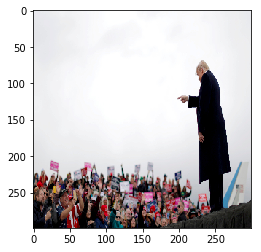

Caption: group of people are standing around fire
_____________________________________


In [12]:
image_path = "D:\\datasets\\image_caption_data\\test4.jpg"
img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
pic = encodeImage(img)
image = pic.reshape((1,OUTPUT_DIM))
plt.imshow(img)
plt.show()
print("Caption:",generateCaption(image))
print("_____________________________________")